In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
df=pd.read_csv("../data/Training_Set_Values.csv")       # Read the Training data CSV file
name_featrures=df.columns                       # Get the features name
len_features=len(name_featrures)                # Get the length of features
labels=pd.read_csv("../data/Training_Set_labels.csv")   # Read the labels (target) CSV file
labels.head()
df['target'] = labels['status_group']   

In [3]:
# Convert the target column to labels 
#print(df['target'].unique())
target_map_dict={'functional': 2, 'functional needs repair': 1, 'non functional': 0} # Defined the mapping of labels to numbers (integers)
#print(df['target'].head())
df['target'] =df['target'].map(target_map_dict) # transform the target column (labels) to  numbers (integers)
#df['target'].head()

In [4]:
X = df.drop(columns=['target'])  # Features only
y = df['target']                 # Target column

In [5]:
from sklearn.model_selection import train_test_split

# Replace with your actual target column name
#target_col = 'status_group'  # Example: use your actual label column
#
#X = df.drop(columns=[target_col])  # Drop target and ID from features
#y = df[target_col]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y
)


In [6]:
# Re-imports after code execution environment reset
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import KFold

class LowerCaseStrings(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self._str_cols = X.select_dtypes(include=["object", "string"]).columns
        return self

    def transform(self, X):
        X = X.copy()
        # operate column-by-column so .str works
        for col in self._str_cols:
            X[col] = X[col].astype("string").str.lower()
        return X

# Re-defining all custom transformers
class StringConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names = X.columns
        return self
    def transform(self, X):
        return X.apply(lambda col: col.astype(str))
    def get_feature_names_out(self, input_features=None):
        return self.feature_names

class YearExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        return self
    def transform(self, X):
        years = pd.to_datetime(X.iloc[:, 0]).dt.year
        years = years.where(years.isin([2011, 2012, 2013]), 2011)
        return pd.DataFrame(years, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class IQRCapper(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='clip', multiplier=1.5):
        self.strategy = strategy
        self.multiplier = multiplier
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        X_series = X.iloc[:, 0]
        self.q1 = X_series.quantile(0.25)
        self.q3 = X_series.quantile(0.75)
        self.iqr = self.q3 - self.q1
        self.lower_bound = self.q1 - self.multiplier * self.iqr
        self.upper_bound = self.q3 + self.multiplier * self.iqr
        self.mean = X_series.mean()
        self.median = X_series.median()
        return self
    def transform(self, X):
        X_series = X.iloc[:, 0].copy()
        if self.strategy == 'clip':
            X_out = X_series.clip(self.lower_bound, self.upper_bound)
        elif self.strategy == 'mean':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.mean)
        elif self.strategy == 'median':
            mask = (X_series < self.lower_bound) | (X_series > self.upper_bound)
            X_out = X_series.mask(mask, self.median)
        else:
            raise ValueError(f"Unknown strategy: {self.strategy}")
        return pd.DataFrame(X_out, columns=[self.feature_name])
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ConstructionYearTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_name = X.columns[0]
        self.median_non_zero = X[X[self.feature_name] != 0][self.feature_name].median()
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.feature_name] = X_copy[self.feature_name].replace(0, self.median_non_zero)
        return X_copy
    def get_feature_names_out(self, input_features=None):
        return [self.feature_name]

class ObjectToNumericConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if hasattr(X, 'columns'):
            X_copy = X.copy()
            for col in X_copy.columns:
                if X_copy[col].dtype == 'object':
                    try:
                        X_copy[col] = pd.to_numeric(X_copy[col])
                    except ValueError:
                        pass
            return X_copy
        else:
            return X  # already numeric


    def get_feature_names_out(self, input_features=None):
        return self.feature_names


class AgeCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, record_col='date_recorded', install_col='construction_year'):
        self.record_col = record_col
        self.install_col = install_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        record_year = pd.to_datetime(X[self.record_col]).dt.year
        age = record_year - X[self.install_col]
        return pd.DataFrame({'age': age})

    def get_feature_names_out(self, input_features=None):
        return ['age']

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps = {}

    def fit(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            freq = X[col].value_counts(normalize=True)
            self.freq_maps[col] = freq.to_dict()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            freq_map = self.freq_maps.get(col, {})
            X[col] = X[col].map(freq_map).fillna(0.0)
        return X

    def get_feature_names_out(self, input_features=None):
        return self.columns

class RegionCodeCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, region_col='region', code_col='region_code', new_col='region_with_code'):
        self.region_col = region_col
        self.code_col = code_col
        self.new_col = new_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_col] = X[self.region_col].astype(str) + "_" + X[self.code_col].astype(str)
        return X


class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.columns_to_drop:
            return X.drop(columns=[col for col in self.columns_to_drop if col in X.columns])
        return X

class GeoContextImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.geo_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        if 'subvillage' in X.columns:
            X['subvillage'] = X['subvillage'].replace('', pd.NA)
            X['subvillage'] = X.apply(lambda row: self.fill_subvillage(row, X), axis=1)
        for col in ['latitude', 'longitude']:
            if col in X.columns:
                X[col] = X[col].apply(lambda x: pd.NA if abs(x) < 1e-6 else x)
        if 'latitude' in X.columns and 'longitude' in X.columns:
            X = self.fill_missing_geo(X, self.geo_group_cols)
        if 'population' in X.columns:
            X['population'] = X['population'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.geo_groupwise_fill(X, 'population', self.geo_group_cols)
        if 'amount_tsh' in X.columns:
            X['amount_tsh'] = X['amount_tsh'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.geo_groupwise_fill(X, 'amount_tsh', self.geo_group_cols)
        if 'permit' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'permit', self.geo_group_cols)
        if 'public_meeting' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'public_meeting', self.geo_group_cols)
        if 'gps_height' in X.columns:
            X['gps_height'] = X['gps_height'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill(X, 'gps_height', self.geo_group_cols)
        if 'construction_year' in X.columns:
            X['construction_year'] = X['construction_year'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill_mode(X, 'construction_year', self.geo_group_cols)
        if 'wpt_name' in X.columns:
            X['wpt_name'] = X['wpt_name'].fillna('none')
        if 'scheme_management' in X.columns:
            X['scheme_management'] = X['scheme_management'].fillna('other')
        if 'funder' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'funder', self.geo_group_cols)
        if 'installer' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'installer', self.geo_group_cols)
        if 'scheme_name' in X.columns:
            X = self.geo_groupwise_fill_mode(X, 'scheme_name', self.geo_group_cols)
        
        #for col in ['funder', 'installer', 'scheme_name']:
         #   if col in X.columns:
         #       X = self.relabel_by_coverage(X, col, threshold=0.1)
        return X.replace({pd.NA: np.nan})

    def fill_subvillage(self, row, df):
        if pd.isna(row['subvillage']):
            for level in ['ward', 'lga', 'district_code']:
                mode = df[df[level] == row[level]]['subvillage'].mode()
                if not mode.empty:
                    return mode[0]
            return 'unknown'
        return row['subvillage']

    def fill_missing_geo(self, df, group_cols):
        for col in group_cols:
            group_means = df.dropna(subset=['latitude', 'longitude']).groupby(col)[['latitude', 'longitude']].mean()
            def fill(row):
                if pd.isna(row['latitude']) or pd.isna(row['longitude']):
                    key = row[col]
                    if key in group_means.index:
                        if pd.isna(row['latitude']):
                            row['latitude'] = group_means.loc[key, 'latitude']
                        if pd.isna(row['longitude']):
                            row['longitude'] = group_means.loc[key, 'longitude']
                return row
            df = df.apply(fill, axis=1)
            if df['latitude'].isna().sum() == 0 and df['longitude'].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill(self, df, target_col, group_cols):
        for col in group_cols:
            group_medians = df.dropna(subset=[target_col]).groupby(col)[target_col].median()
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_medians.index:
                        row[target_col] = group_medians.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def geo_groupwise_fill_mode(self, df, target_col, group_cols):
        for col in group_cols:
            group_modes = df.dropna(subset=[target_col]).groupby(col)[target_col].agg(lambda x: x.mode().iloc[0])
            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_modes.index:
                        row[target_col] = group_modes.loc[key]
                return row
            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break
        return df

    def relabel_by_coverage(self, df, column, threshold=0.5, new_label='other'):
        value_counts = df[column].value_counts(normalize=True)
        cumulative = value_counts.cumsum()
        keep_labels = cumulative[cumulative <= threshold].index.tolist()
        df[column] = df[column].apply(lambda x: x if x in keep_labels else new_label)
        return df


In [7]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.feature_selection import SelectFromModel


# 1. Initial preprocessing (geo imputation + drop columns)
columns_to_drop=['id','num_private','recorded_by',
              'extraction_type_group','extraction_type',
              'quality_group','quantity_group','source','waterpoint_type_group', 'region'
                
                 #'wpt_name','scheme_management', 'funder', 'installer','scheme_name', 'payment', 'public_meeting', 'permit', 'region',  'subvillage', 'ward','lga'
             ]
high_card_cols = ['funder', 'installer', 'wpt_name', 'ward', 'lga', 'scheme_management', 'scheme_name', 'subvillage', 'management']

initial_preprocessing = Pipeline([
    ('geo_imputer', GeoContextImputer()),
    ('region_combiner', RegionCodeCombiner()),  # <- Add this
    ('dropper', ColumnDropper(columns_to_drop=columns_to_drop))
])
# Step 2: Apply initial transformation
intermediate = initial_preprocessing.fit_transform(X_train.copy())
numeric_features = intermediate.select_dtypes(include='number').columns.tolist()
categorical_features = intermediate.select_dtypes(include='object').columns.tolist()

#adding the two features to caregorical explicitly, and removing from numerical.
categorical_features.append('region_with_code')
categorical_features.append('district_code')

if 'district_code' in numeric_features:
    numeric_features.remove('district_code')

if 'region_code' in numeric_features:
    numeric_features.remove('region_code')

#⚠️ Remove columns used by age pipeline so they are not reused elsewhere

for col in high_card_cols:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)

for col in ['construction_year']:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)

for col in ['date_recorded']:
    if col in numeric_features:
        numeric_features.remove(col)
    if col in categorical_features:
        categorical_features.remove(col)

# ✅ De-duplicate and check overlaps between numeric and categorical
categorical_features = list(set(categorical_features))  # Remove duplicates
numeric_features = list(set(numeric_features))          # Optional: do the same for numeric
assert not set(numeric_features) & set(categorical_features), "❌ Overlap between numeric and categorical features"

high_card_pipeline = Pipeline([
    ('freq_encoder', FrequencyEncoder(columns=high_card_cols)),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # optional
    ('scaler', StandardScaler())
])


#for col in ['funder']:
#    if col in numeric_features:
#        numeric_features.remove(col)
#    if col in categorical_features:
#        categorical_features.remove(col)


# 3. Build per-type transformers
numeric_transformer = Pipeline([
    ('iqr_cap', IQRCapper(strategy='clip')),
    ('scaler', StandardScaler())
])

class AgePipeline(SklearnPipeline):
    def get_feature_names_out(self, input_features=None):
        return ['age']

age_pipeline = AgePipeline([
    ('age_calc', AgeCalculator()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('string_converter', StringConverter()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Use sparse=False if needed
])

# 4. Assemble preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_pipeline, ['date_recorded', 'construction_year']),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('freq', high_card_pipeline, high_card_cols)
    ],
    sparse_threshold=0,
#    verbose_feature_names_out=True  # 👈 add this
)



# Insert it into the pipeline
full_pipeline = Pipeline([
    ("lowercase", LowerCaseStrings()),
    ('geo_imputer', GeoContextImputer()),
    ('region_combiner', RegionCodeCombiner()),
    ('dropper', ColumnDropper(columns_to_drop=columns_to_drop)),
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold=0.001)),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', n_jobs=-1))
])


Seaprating the model from the pipeline, to create two separate joblib files for Shakeel

In [19]:
from sklearn.pipeline import Pipeline

transform_pipeline = Pipeline([
    ("lowercase", LowerCaseStrings()),
    ("geo_imputer", GeoContextImputer()),
    ("region_combiner", RegionCodeCombiner()),
    ("dropper", ColumnDropper(columns_to_drop=columns_to_drop)),
    ("preprocessor", preprocessor),
    ("feature_selection", SelectFromModel(RandomForestClassifier(), threshold=0.001)),
])


In [20]:
X_train_fs = transform_pipeline.fit_transform(X_train, y_train)
X_test_fs = transform_pipeline.transform(X_test)


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
joblib.dump(transform_pipeline,"preprocessor.joblib")

['preprocessor.joblib']

In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train_fs, y_train)


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf_model.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1)

In [29]:
joblib.dump(rf_model, f"RF_model.joblib")

['RF_model.joblib']

In [27]:
from sklearn.metrics import accuracy_score


y_pred = rf_model.predict(X_test_fs)
print(accuracy_score(y_test, y_pred) )


0.7850729517396184


Back to full pipeline as before

In [8]:
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)


In [9]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.7828282828282829


In [10]:
import joblib
# save the model
joblib.dump(
    full_pipeline,          # the fitted object
    "RFC_01.joblib", # target file
    compress=3              # optional: 0-9, trade-off speed vs. size
)

['RFC_01.joblib']

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(full_pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy')
print("Average CV accuracy:", scores.mean())


In [11]:
# 1. Get the trained RandomForestClassifier
rf_model = full_pipeline.named_steps['classifier']

# 2. Get the ColumnTransformer directly
column_transformer = full_pipeline.named_steps['preprocessor']

# 3. Initialize feature name list
feature_names = []

# 4. Loop through transformers
# 4. Loop through transformers
for name, transformer, cols in column_transformer.transformers_:
    if name == 'cat':  # Categorical pipeline with OneHotEncoder
        ohe = transformer.named_steps['ohe']
        ohe_feature_names = ohe.get_feature_names_out(cols)
        feature_names.extend(ohe_feature_names)
    elif name == 'num':  # Numerical pipeline
        feature_names.extend(cols)
    elif name == 'age':  # ✅ Include age pipeline
        if hasattr(transformer, 'get_feature_names_out'):
            age_feature_names = transformer.get_feature_names_out()
        else:
            age_feature_names = ['age']
        # Prefix with 'age__' for consistency with ColumnTransformer
        feature_names.extend(['age__' + fname for fname in age_feature_names])
    elif name == 'remainder' and transformer == 'passthrough':
        feature_names.extend(cols)


# 5. Combine with feature importances
importances = rf_model.feature_importances_
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# 6. Display top features
print("🔝 Top 30 Feature Importances:")
for name, score in feature_importances[:300]:
    print(f"{name}: {score:.4f}")


🔝 Top 30 Feature Importances:
basin_lake rukwa: 0.0715
population: 0.0658
age__age: 0.0620
payment_pay per bucket: 0.0577
basin_lake nyasa: 0.0552
payment_pay monthly: 0.0526
payment_other: 0.0453
longitude: 0.0409
payment_pay when scheme fails: 0.0405
payment_pay annually: 0.0369
amount_tsh: 0.0290
quantity_enough: 0.0215
extraction_type_class_other: 0.0211
payment_unknown: 0.0182
district_code_6: 0.0168
basin_lake tanganyika: 0.0158
quantity_seasonal: 0.0142
region_with_code_mara_20: 0.0128
management_group_other: 0.0121
district_code_43: 0.0117
district_code_5: 0.0111
district_code_8: 0.0099
quantity_unknown: 0.0095
management_group_unknown: 0.0088
district_code_4: 0.0085
region_with_code_morogoro_5: 0.0083
waterpoint_type_communal standpipe: 0.0082
region_with_code_tanga_5: 0.0080
region_with_code_mbeya_12: 0.0078
extraction_type_class_handpump: 0.0077
region_with_code_ruvuma_10: 0.0076
quantity_insufficient: 0.0073
district_code_53: 0.0073
region_with_code_lindi_18: 0.0072
extract

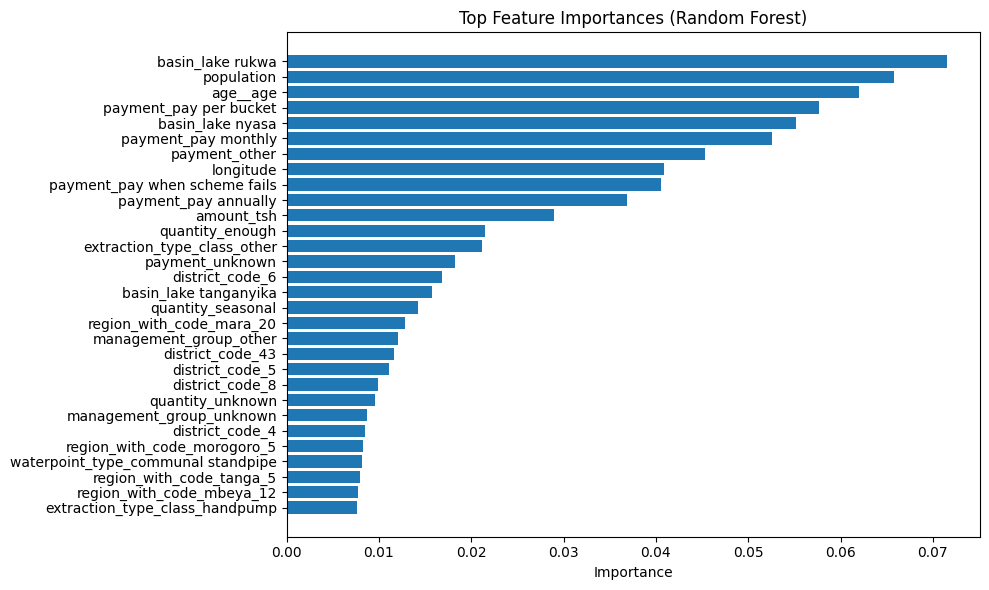

In [12]:
import matplotlib.pyplot as plt

top_n = 30
names, scores = zip(*feature_importances[:top_n])

plt.figure(figsize=(10, 6))
plt.barh(names[::-1], scores[::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Time to bring in the actual test set for making the submission to the competiton

In [17]:
df_3 = pd.read_csv("../data/Test_Set_Values.csv")

In [18]:
X_test_ids = df_3['id'].copy()  # Store before dropping

In [19]:
preds_test = full_pipeline.predict(df_3)

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
# Correctly map ints to strings
reverse_target_map = {0: 'non functional', 1: 'functional needs repair', 2: 'functional'}
y_pred_labels = [reverse_target_map[int(p)] for p in preds_test]  # Ensure int keys

# Create DataFrame
submission = pd.DataFrame({
    "id": X_test_ids.values,
    "status_group": y_pred_labels
})
submission.to_csv("submission_2.csv", index=False)


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def find_ohe_blocks(column_transformer: ColumnTransformer):
    """
    Return a list of tuples (block_name, columns, fitted_encoder)
    for every OneHotEncoder inside a (possibly nested) ColumnTransformer.
    """
    ohe_blocks = []

    for name, trans, cols in column_transformer.transformers_:
        if trans in ("drop", "passthrough"):
            continue

        # Handle the common pattern of a sub-Pipeline:  ("cat", Pipeline(...), cols)
        if isinstance(trans, Pipeline):
            for step in trans.steps:
                if isinstance(step[1], OneHotEncoder):
                    ohe_blocks.append((name, cols, step[1]))
        # Plain OneHotEncoder directly in the ColumnTransformer
        elif isinstance(trans, OneHotEncoder):
            ohe_blocks.append((name, cols, trans))

    return ohe_blocks


In [35]:
print(X_test.columns)

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


In [31]:
# full_pipeline is YOUR fitted pipeline variable
prep = full_pipeline.named_steps["preprocessor"]     # adjust if you used another key
ohe_blocks = find_ohe_blocks(prep)

# If you only have one categorical block:
block_name, cat_cols, enc = ohe_blocks[0]
print("Categorical block:", block_name)
print("Columns feeding the encoder:", cat_cols)



Categorical block: cat
Columns feeding the encoder: ['management_group', 'quantity', 'extraction_type_class', 'waterpoint_type', 'region_with_code', 'district_code', 'payment', 'basin', 'source_type', 'source_class', 'payment_type', 'water_quality']


In [34]:
import pandas as pd

def unknown_categories(X_slice: pd.DataFrame, encoder: OneHotEncoder, cols):
    """Return {column_name: {set of unseen categories}}."""
    unseen = {}
    for i, col in enumerate(cols):
        seen = set(encoder.categories_[i])          # what the encoder learned at fit-time
        now  = set(X_slice[col].dropna().unique())  # what we see in this data split
        diff = now - seen
        if diff:
            unseen[col] = diff
    return unseen

# Example inside a CV loop (the data split that triggered the warning):
for block_name, cols, enc in ohe_blocks:
    diff = unknown_categories(X_test[cols], enc, cols)
    if diff:
        print(f"\n⚠️  Block '{block_name}' has unseen categories:")
        for c, vals in diff.items():
            print(f"  • {c}: {sorted(vals)}")


KeyError: "['region_with_code'] not in index"

Submitting resut on drivendata with testset, public score = 0.7891

In [12]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'classifier__n_estimators': [300, 500, 700],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

search = RandomizedSearchCV(full_pipeline, param_dist, cv=3, n_iter=30, scoring='balanced_accuracy', n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best cross-validation score:", search.best_score_)

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

Best parameters: {'classifier__n_estimators': 500, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}
Best cross-validation score: 0.6832988162166359


In [21]:
full_pipeline = Pipeline([
    ("lowercase", LowerCaseStrings()),
    ('geo_imputer', GeoContextImputer()),
    ('region_combiner', RegionCodeCombiner()),
    ('dropper', ColumnDropper(columns_to_drop=columns_to_drop)),
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(), threshold=0.001)),
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1,
                                          min_samples_leaf=4,max_features='sqrt', max_depth=20))
])

In [22]:
from sklearn.metrics import accuracy_score

full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.757351290684624


In [ ]:
#GridSearch

from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [300, 500, 700],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='balanced_accuracy',  # or 'f1_macro', etc.
    n_jobs=-1,  # parallel processing
    verbose=2
)

Optimization using gridsearch

In [17]:
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 3 folds for each of 162 candidates, totalling 486 fits


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 6.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 6.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 6.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 4.5min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 6.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_feat

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.4min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.4min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 5.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_feat

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.4min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.4min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 6.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.8min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__max_feat

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 5.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 4.7min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 8.1min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 8.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 5.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 8.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 8.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 8.4min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 8.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 8.5min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 8.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 7.2min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 8.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 7.2min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 8.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 7.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.4min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_fea

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 5.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 7.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 8.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_featu

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 8.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 8.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 7.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 5.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_fe

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 7.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 5.4min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 8.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 5.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 4.8min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 7.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 8.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__max_fe

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 4.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 5.0min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 5.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifi

/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 5.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 5.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.8min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 8.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=300; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=500; total time= 8.8min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 5.3min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 5.1min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time= 4.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 9.0min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__n_estimators=500; total time= 4.8min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=700; total time= 9.0min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__n_estimators=700; total time= 4.9min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 8.7min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 9.2min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=1, classifier__n_estimators=300; total time= 8.2min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=500; total time= 8.6min
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__max_features=0.5, classifier__min_samples_leaf=4, classifier__n_estimators=700; total time= 7.5min


/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/amey/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:24

KeyboardInterrupt: 

In [19]:
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Evaluation metrics

📊 Accuracy: 0.7801346801346801
🎯 Precision (macro): 0.6796705561120845
🎯 Recall (macro): 0.6801552438206175
🎯 F1 Score (macro): 0.6795393774125428
🎯 F1 Score (weighted): 0.7804388328976993
🧠 Cohen’s Kappa: 0.6004571281968947
📉 Log Loss: 0.5877013723416928
📈 ROC AUC Score (OvR): 0.8853748215367395

🧾 Classification Report:
                         precision    recall  f1-score   support

         non functional       0.81      0.77      0.79      3424
functional needs repair       0.42      0.44      0.43       647
             functional       0.81      0.84      0.82      4839

               accuracy                           0.78      8910
              macro avg       0.68      0.68      0.68      8910
           weighted avg       0.78      0.78      0.78      8910



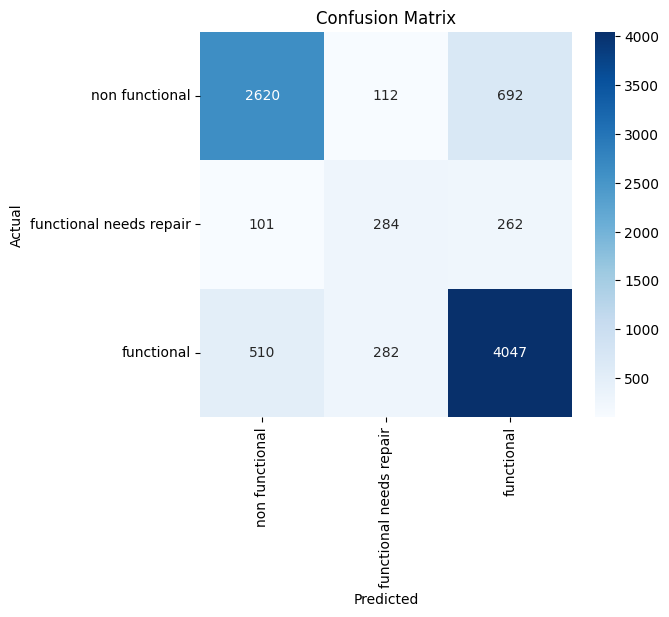


🔍 Class distribution comparison:
Predicted: 0    0.362626
1    0.076094
2    0.561279
Name: proportion, dtype: float64
True:      target
0    0.384287
1    0.072615
2    0.543098
Name: proportion, dtype: float64


In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss,
    roc_auc_score, cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

inv_target_map = {v: k for k, v in target_map_dict.items()}
class_names = [inv_target_map[i] for i in sorted(inv_target_map)]

# Label decoding if needed
y_true = y_test
y_pred_labels = y_pred  # use inverse_transform(y_pred) if label encoded
y_proba = full_pipeline.predict_proba(X_test)  # must be available for log_loss/roc_auc

# Basic Scores
print("📊 Accuracy:", accuracy_score(y_true, y_pred_labels))
print("🎯 Precision (macro):", precision_score(y_true, y_pred_labels, average='macro'))
print("🎯 Recall (macro):", recall_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (macro):", f1_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (weighted):", f1_score(y_true, y_pred_labels, average='weighted'))

# Cohen's Kappa
print("🧠 Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred_labels))

# Log Loss (requires probabilities)
try:
    print("📉 Log Loss:", log_loss(y_true, y_proba))
except:
    print("⚠️ Log loss not available (no predict_proba)")

# ROC AUC (multiclass)
try:
    print("📈 ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))
except:
    print("⚠️ ROC AUC not available (no predict_proba)")

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Prediction Distribution vs True Distribution
print("\n🔍 Class distribution comparison:")
print("Predicted:", pd.Series(y_pred_labels).value_counts(normalize=True).sort_index())
print("True:     ", pd.Series(y_true).value_counts(normalize=True).sort_index())


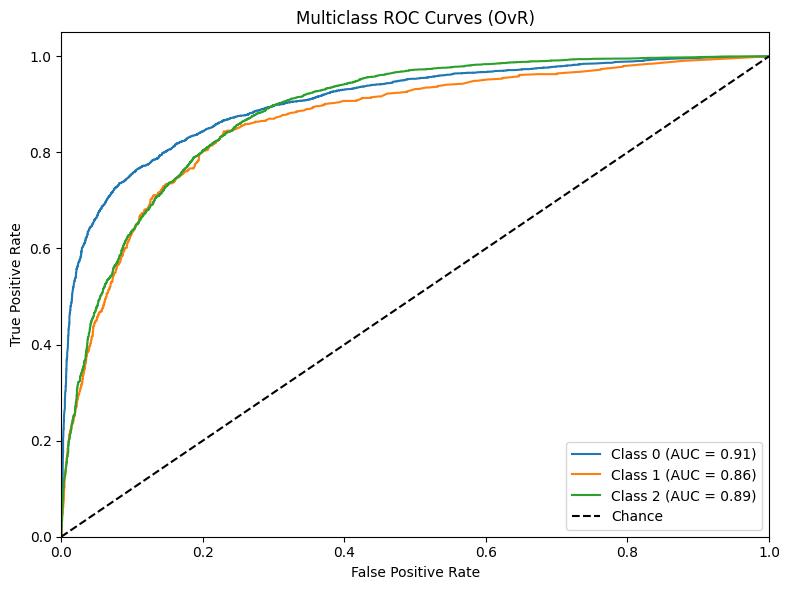

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming y_true (integer labels) and y_proba (n_samples x n_classes)
# Also, target_map_dict = {'functional': 2, 'functional needs repair': 1, 'non functional': 0}
# Reverse map and binarize
classes = [0, 1, 2]  # or sorted list(target_map_dict.values())
y_test_bin = label_binarize(y_true, classes=classes)
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


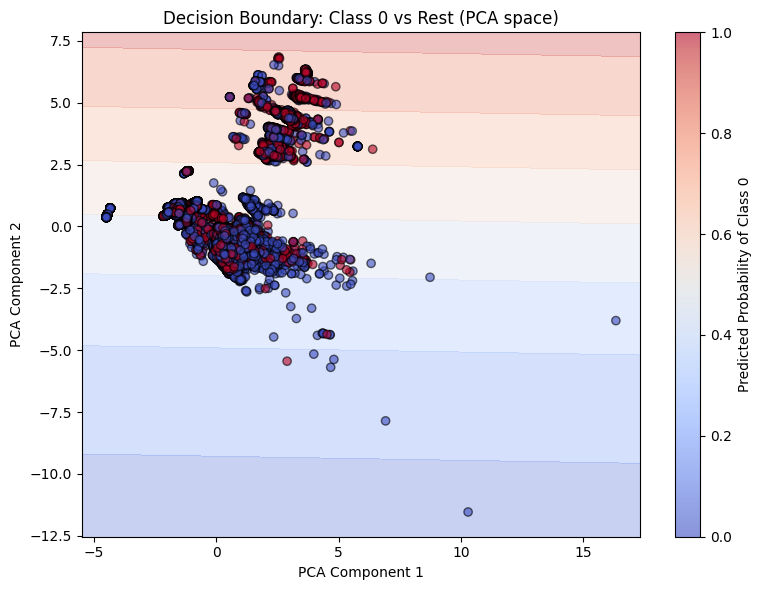

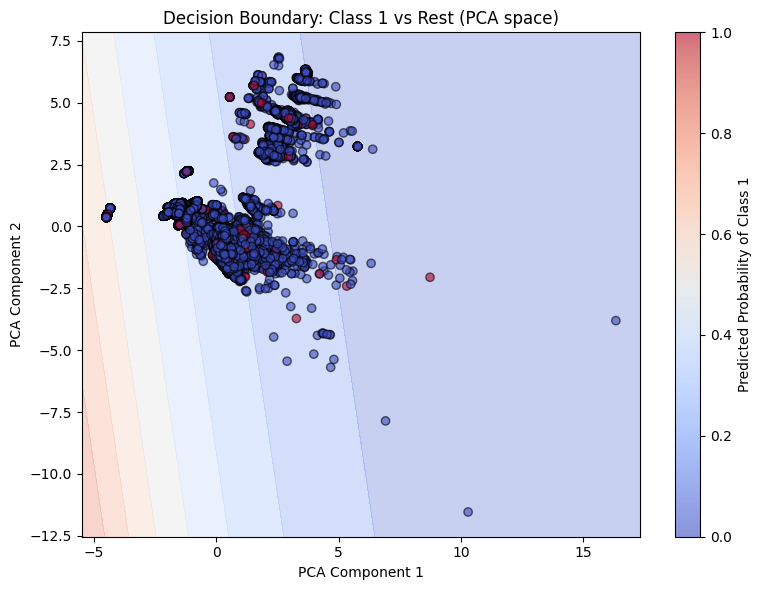

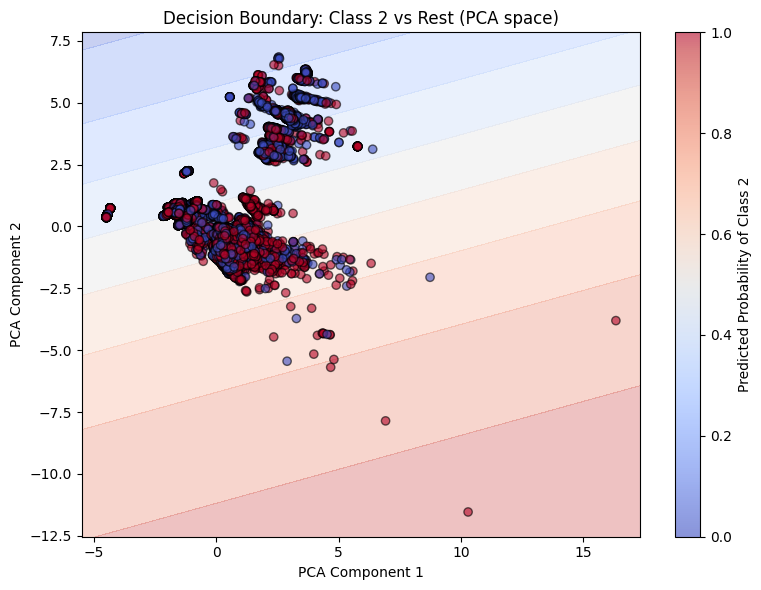

In [15]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Keep only numeric features
X_numeric = X.select_dtypes(include=[np.number])

# Step 2: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Step 3: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 4: Loop through each class
unique_classes = np.unique(y)  # e.g., [0, 1, 2]

for cls in unique_classes:
    # Create binary target: 1 for current class, 0 for others
    y_binary = (y == cls).astype(int)

    # Train 1-vs-rest classifier
    clf = LogisticRegression()
    clf.fit(X_pca, y_binary)

    # Generate meshgrid for decision boundary
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"Decision Boundary: Class {cls} vs Rest (PCA space)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label=f"Predicted Probability of Class {cls}")
    plt.tight_layout()
    plt.show()


TSNE Plots look strange but interesting.

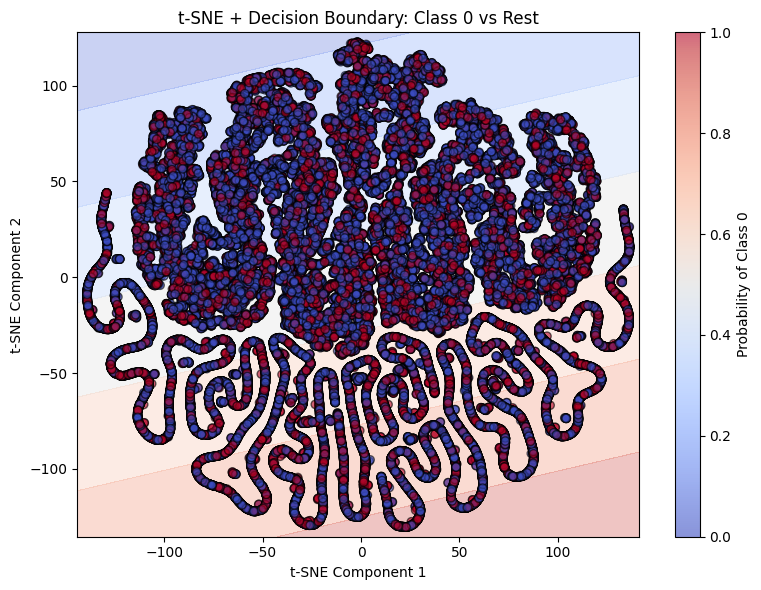

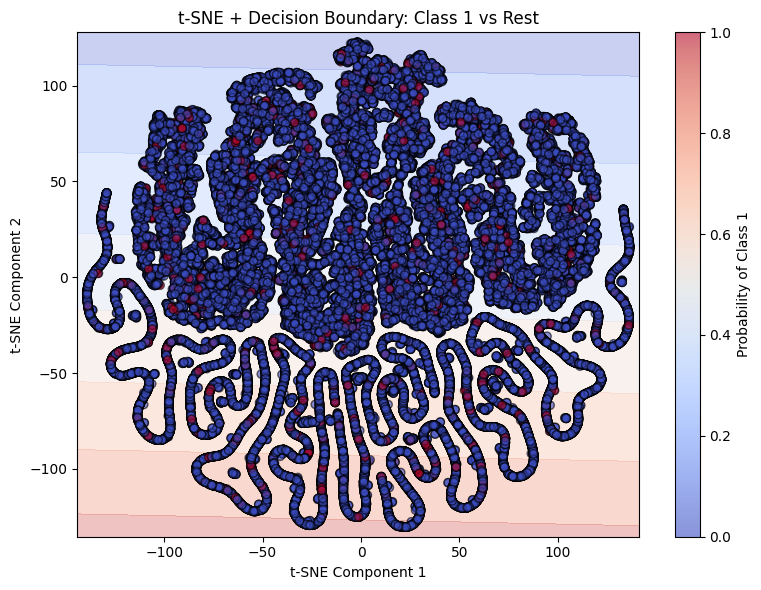

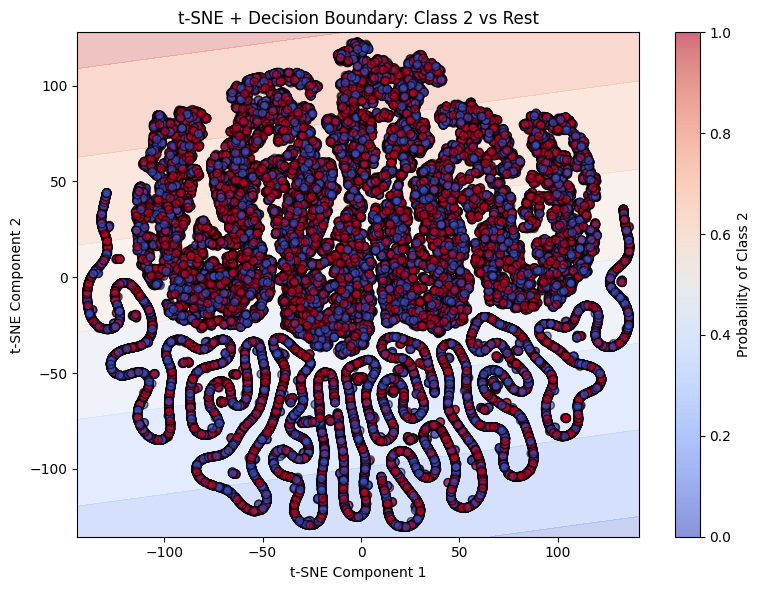

In [16]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_numeric)  # X_numeric: only numeric features

# Step 2: Loop through each class for 1-vs-rest
for cls in np.unique(y):
    y_binary = (y == cls).astype(int)

    clf = LogisticRegression()
    clf.fit(X_tsne, y_binary)

    # Decision boundary
    x_min, x_max = X_tsne[:, 0].min() - 5, X_tsne[:, 0].max() + 5
    y_min, y_max = X_tsne[:, 1].min() - 5, X_tsne[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_binary, edgecolors='k',
                cmap='coolwarm', alpha=0.6)
    plt.title(f"t-SNE + Decision Boundary: Class {cls} vs Rest")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.colorbar(label=f"Probability of Class {cls}")
    plt.tight_layout()
    plt.show()
